In [1]:
import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word

n, s = Ty('n'), Ty('s')
# nlp = spacy.load("ja_core_web_sm")
nlp = spacy.load("ja_ginza")
# nlp = spacy.load("en_core_web_trf")
# モデルの大きさによって解析精度に差あり

c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
sentence = '熟練した男は料理を作る。'
doc = nlp(sentence)
displacy.serve(doc, style='dep', port=5001)

for token in doc:
    print(token.text+'<-'+token.head.text,token.dep_)

# 文頭を大文字、文末にピリオド をちゃんとやると正確になりやすいかも

c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\spacy\displacy\__init__.py:106: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5001 ...

Shutting down server on port 5001.
熟練<-男 acl
し<-熟練 aux
た<-熟練 aux
男<-作る nsubj
は<-男 case
料理<-作る obj
を<-料理 case
作る<-作る ROOT
。<-作る punct


In [12]:
# 型の割り当て
def assign_types_in_order(doc):
    pregroup_types = {}
    doc = nlp(sentence)
    # トークン化
    tokens = [token.text for token in doc]
    # 依存関係をまとめる
    # dependencies = [(token.text, token.head.text) for token in doc if token.text != "."]
    needed_words = []
    
    for token in doc:
        if token.dep_ == 'ROOT' or token.pos_ in ['NOUN','PRON']:
            needed_words.append(token.text)
            
    # 依存関係による型の割り当て（ペアと語順）
    for i in range(len(needed_words)):
        word_in_needed_words = needed_words[i]
        if i == 0:
            pregroup_types[word_in_needed_words] = n
        elif i < len(needed_words) -1:
            pregroup_types[word_in_needed_words] = n.r @ n
        elif i == len(needed_words) -1:
            pregroup_types[word_in_needed_words] = n.r @ s
        
    return pregroup_types

In [13]:
sentence = '熟練した男は料理を作る。'
types = assign_types_in_order(sentence)
print(types)

{'男': Ty(n), '料理': Ty(n).r @ Ty(n), '作る': Ty(n).r @ Ty(s)}


In [15]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

# 日本語フォントを設定
font_path = "C:\\Windows\\Fonts\\meiryo.ttc" 
jp_font = fm.FontProperties(fname=font_path) 
# matplotlibにフォントを設定
rcParams['font.family'] = jp_font.get_name()

# diagram作成
def create_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = assign_types_in_order(doc)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # カップ構造を作る
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s @ s.r:
            diagram = diagram >> types[:i] @ Cup(s, s.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s.l @ s:
            diagram = diagram >> types[:i] @ Cup(s.l, s) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

熟練した男は料理を作る。


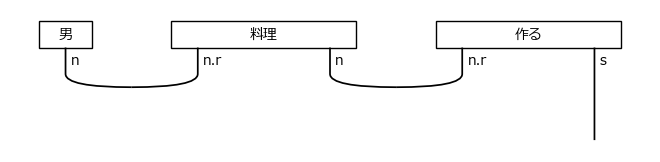

In [16]:
sentence = '熟練した男は料理を作る。'
diagram = create_diagram(sentence)
print(sentence)
draw(diagram)

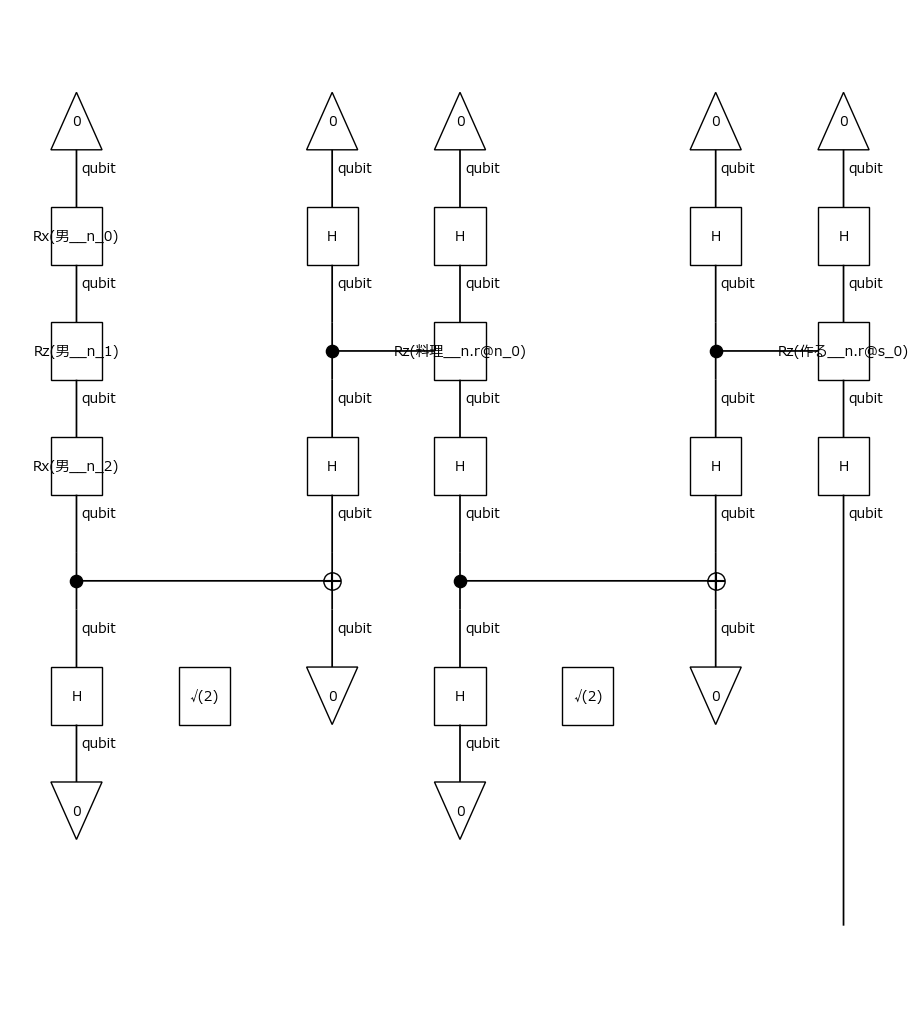

In [17]:
from lambeq import AtomicType, IQPAnsatz
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

circuit = ansatz(diagram)

circuit.draw(figsize=(9, 10))